# Measurement

We support the following measurements:

- spectroscopy
- lifetime
- Rabi oscillation

In [9]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pydatatom import *

%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
raw_dataset = GzipPickleDataset("/tmp/AA_clock_spect")

prob_pipeline = Pipeline(steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    AtomStatsStep(),
])
prob_pipeline.fit(raw_dataset)

In [11]:
prob_dataset = prob_pipeline.transform(raw_dataset)

prob_df = Transform(prob_dataset, [
    lambda p: { "probability": p.tolist() }
]).to_pandas()
meta_df = Transform(raw_dataset, [
    PickType(float),
]).to_pandas()

df = pd.concat([meta_df, prob_df], axis=1)
df = df.dropna()
df = df.loc[:, df.nunique(dropna=True).ne(1)].copy() 
df.head()

,run,TC_systime_sec,df_yellow_AOM,f_clock_fundamental_large_sideband,probability
0,11260.0,8.714378e+13,0.001050,196.116356,0.692308
3,12366.0,8.798405e+13,0.000875,196.116386,0.818182
4,11200.0,8.709818e+13,-0.002275,196.116355,1.000000
5,697.0,8.890266e+13,-0.003500,196.116418,0.916667
6,11309.0,8.718091e+13,0.002450,196.116358,0.857143


In [12]:
df['df_clock_fundamental'] = df['f_clock_fundamental_large_sideband'] - 2*df['df_yellow_AOM']
df.head()

,run,TC_systime_sec,df_yellow_AOM,f_clock_fundamental_large_sideband,probability,df_clock_fundamental
0,11260.0,8.714378e+13,0.001050,196.116356,0.692308,196.114256
3,12366.0,8.798405e+13,0.000875,196.116386,0.818182,196.114636
4,11200.0,8.709818e+13,-0.002275,196.116355,1.000000,196.120905
5,697.0,8.890266e+13,-0.003500,196.116418,0.916667,196.123418
6,11309.0,8.718091e+13,0.002450,196.116358,0.857143,196.111458


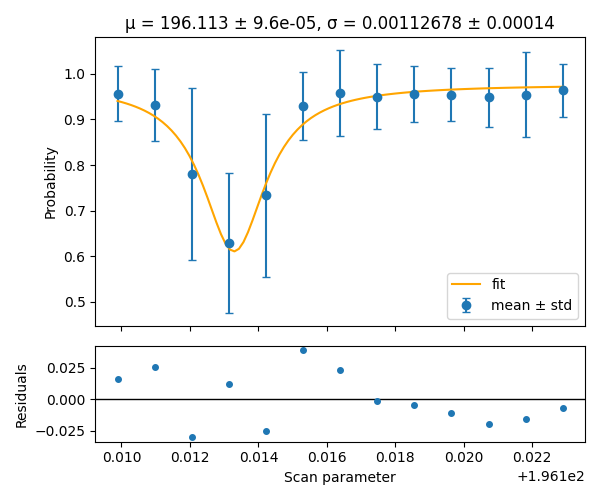

In [33]:
measurement = Spectroscopy()
measurement.fit(df['df_clock_fundamental'].to_numpy(), df['probability'].to_numpy())
measurement.plot()